###  Clusters de mélange gaussien, clustering 

L’algorithme GMM (Mélange gaussien) permet de déterminer les différents clusters en séparant 
les données contenues dans les différentes courbes en forme cloche. 

Pour chaque cluster, l’algorithme détermine une moyenne et une variance, puis pour chaque observation il détermine une probabilité d’appartenir ou non à ce cluster.


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np


Les clusters GMM sont intéressqnts quand les clusters ne sont pas circulaire comme les K-means, le 
model GMM essaiera de trouver une probaibilté de distribution multi-dimensionnelle.


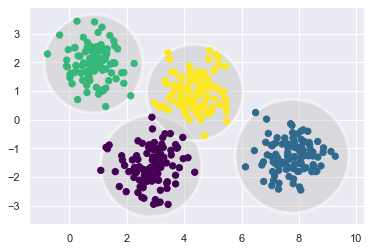

In [9]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import mixture

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
kmeans = KMeans(4, random_state=0)
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)        


- Avec les Gmms vous pouvez identifier des clusters plus complexes 

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

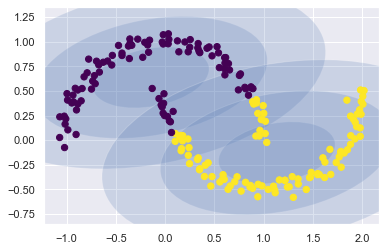

In [11]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)

gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)




### Paramétrage du modèle GMM

- Recherche du nombre de clusters optimal qui va minimiser les critères AIC et BIC, et maximizer le coefficient de silouette

we can evaluate the likelihood of the data under the model, 
using cross-validation to avoid over-fitting. 
Another means of correcting for over-fitting is to adjust the model likelihoods 
using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC). 
Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, 
and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

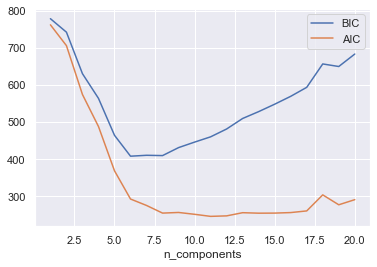

In [12]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

Nous cherchons un nombre optimal de clusters qui minimize les valeurs de AIC ou BIC.
L'AIC nous donne une plage de valeurs de 8 à 12 clusters, alors que le BIC recommande une valeur comprise entre 6 et 8 clusters.


- Coefficient de Silouette

Text(0, 0.5, 'Coefficient')

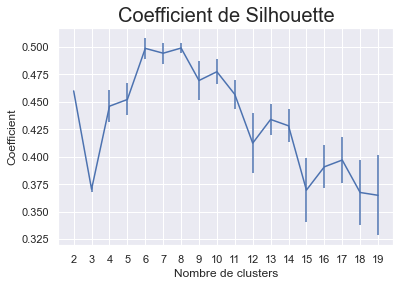

In [13]:
from sklearn import metrics

def SelBest(arr:list, X:int)->list:
    ''' returns the set of X configurations with shorter distance '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

n_clusters=np.arange(2, 20)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm = mixture.GaussianMixture(n, n_init=2).fit(Xmoon) 
        labels = gmm.predict(Xmoon)
        sil = metrics.silhouette_score(Xmoon, labels, metric='euclidean')
        tmp_sil.append(sil)
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err = np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)
    
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Coefficient de Silhouette", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("Nombre de clusters")
plt.ylabel("Coefficient")    

- Nous observons le meilleur coefficient de silouette avec 6 clusters

- Discussion: L'étude des indicateurs AIC, BIC, Silouette nous incite à choisir 6 pour le nombre de Clusters

### Modelisation

In [31]:

# Select data for clustering model
X = Xmoon
n_components = 6
# Set the model and its parameters - 6 clusters
gmm = mixture.GaussianMixture(n_components=n_components, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100,           # the number of EM iterations to perform. default=100
                         n_init=1,               # the number of initializations to perform. default = 1
                         init_params='kmeans',   # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0,              # default 0, {0,1,2}
                         random_state=1          # for reproducibility
                        )

# Fit the model and predict labels
clust = gmm.fit(X)
labels = gmm.predict(X)

# Print model summary
print('*************** Cluster Model ***************')
print('Converged: ', clust.converged_)
# print('Weights: ', clust.weights_)
print('Means: ', clust.means_)
# print('Covariances: ', clust.covariances_)
# print('Precisions: ', clust.precisions_)
# print('Precisions Cholesky: ', clust4.precisions_cholesky_)
print(' No. of Iterations: ', clust.n_iter_)
#print('Lower Bound: ', clust.lower_bound_)

*************** Cluster Model ***************
Converged:  True
Means:  [[ 1.05098161 -0.43853373]
 [-0.01932392  0.95456503]
 [ 1.85562665  0.06650545]
 [-0.84573121  0.47122069]
 [ 0.15531801  0.04093934]
 [ 0.81330854  0.47439342]]
 No. of Iterations:  9


In [30]:
for i, v in enumerate(X):
    print(v, '\t->', labels[i])

[0.81680544 0.5216447 ] 	-> 5
[ 1.61859642 -0.37982927] 	-> 0
[-0.02126953  0.27372826] 	-> 4
[-1.02181041 -0.07543984] 	-> 3
[ 1.76654633 -0.17069874] 	-> 2
[ 1.8820287  -0.04238449] 	-> 2
[0.97481551 0.20999374] 	-> 5
[ 0.88798782 -0.48936735] 	-> 0
[0.89865156 0.36637762] 	-> 5
[ 1.11638974 -0.53460385] 	-> 0
[-0.36380036  0.82790185] 	-> 1
[ 0.24702417 -0.23856676] 	-> 4
[ 1.81658658 -0.13088387] 	-> 2
[ 1.2163905  -0.40685761] 	-> 0
[-0.8236696   0.64235178] 	-> 3
[0.98065583 0.20850838] 	-> 5
[0.54097175 0.88616823] 	-> 5
[ 0.348031   -0.30101351] 	-> 4
[0.35181497 0.88827765] 	-> 1
[-0.77708642  0.82253872] 	-> 3
[1.92590813 0.01214146] 	-> 2
[ 0.86096723 -0.47653216] 	-> 0
[0.19990695 0.99672359] 	-> 1
[ 1.2895301  -0.37071087] 	-> 0
[-0.27847636  1.02538452] 	-> 1
[ 0.24187916 -0.07627812] 	-> 4
[ 1.84988768 -0.09773674] 	-> 2
[1.88406869 0.0449402 ] 	-> 2
[ 0.165822   -0.08613126] 	-> 4
[0.13861369 0.89639036] 	-> 1
[0.89087024 0.52265882] 	-> 5
[-0.22806587  0.84091882] 	-> 